**[인공지능기초]** 중간과제

---

**주제** : Gender Recognition by Voice

**목표** : 남성과 여성의 음성 및 발성을 분석하여 얻은 3,168개의 샘플 데이터를 사용하여, 기계학습 알고리즘에 적용해 성별별 목소리의 특성을 학습한다.

**0) Importing Various Modules**

학습에 필요한 모듈들을 임포트 한다.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import pandas as pd
import seaborn as sns
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from google.colab import files

**1) Loading the Dataset**

Datasets 은 kaggle에서 다운받을 수 있다.

https://www.kaggle.com/primaryobjects/voicegender

여기서는 colab에서 바로 kaggle 사이트의 Dataset을 불러오는 방식을 사용하였다.


그러기 위해 kaggle.json파일을 업로드한다.

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
uploaded = files.upload()

Saving kaggle.json to kaggle.json


kaggle에서 Dataset를 받아 압축을 해제한 뒤, 해제된 csv 파일을 확인한다.

In [ ]:
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d primaryobjects/voicegender
!unzip 'voicegender.zip'
!ls

  0% 0.00/405k [00:00<?, ?B/s]
100% 405k/405k [00:00<00:00, 60.8MB/s]
Archive:  voicegender.zip
  inflating: voice.csv               
kaggle.json  sample_data  voice.csv  voicegender.zip


받아온 Dataset의 크기와 정보를 확인한다.

In [ ]:
data_voice = pd.read_csv('voice.csv')
data = data_voice.copy()
print(data.shape)
data.info()

(3168, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   meanfreq  3168 non-null   float64
 1   sd        3168 non-null   float64
 2   median    3168 non-null   float64
 3   Q25       3168 non-null   float64
 4   Q75       3168 non-null   float64
 5   IQR       3168 non-null   float64
 6   skew      3168 non-null   float64
 7   kurt      3168 non-null   float64
 8   sp.ent    3168 non-null   float64
 9   sfm       3168 non-null   float64
 10  mode      3168 non-null   float64
 11  centroid  3168 non-null   float64
 12  meanfun   3168 non-null   float64
 13  minfun    3168 non-null   float64
 14  maxfun    3168 non-null   float64
 15  meandom   3168 non-null   float64
 16  mindom    3168 non-null   float64
 17  maxdom    3168 non-null   float64
 18  dfrange   3168 non-null   float64
 19  modindx   3168 non-null   float64
 20  label     3168 non-

CSV 파일은 다음과 같은 음향 특성들로 구성되어 있다.

- **meanfreq**: mean frequency (in kHz)
- **sd**: standard deviation of frequency
- **median**: median frequency (in kHz)
- **Q25**: first quantile (in kHz)
- **Q75**: third quantile (in kHz)
- **IQR**: interquantile range (in kHz)
- **skew**: skewness (see note in specprop description)
- **kurt**: kurtosis (see note in specprop description)
- **sp.ent**: spectral entropy
- **sfm**: spectral flatness
- **mode**: mode frequency
- **centroid**: frequency centroid (see specprop)
- **peakf**: peak frequency (frequency with highest energy)
- **meanfun**: average of fundamental frequency measured across acoustic signal
- **minfun**: minimum fundamental frequency measured across acoustic signal
- **maxfun**: maximum fundamental frequency measured across acoustic signal
- **meandom**: average of dominant frequency measured across acoustic signal
- **mindom**: minimum of dominant frequency measured across acoustic signal
- **maxdom**: maximum of dominant frequency measured across acoustic signal
- **dfrange**: range of dominant frequency measured across acoustic signal
- **modindx**: modulation index. Calculated as the accumulated absolute difference between adjacent measurements of fundamental frequencies divided by the frequency range
- **label**: male or female

**2) Data Visualization**

성별에 따른 각 데이터의 특징을 시각화 하여 비교해 보기 위해 다음과 같이 그래프로 나타내었다.

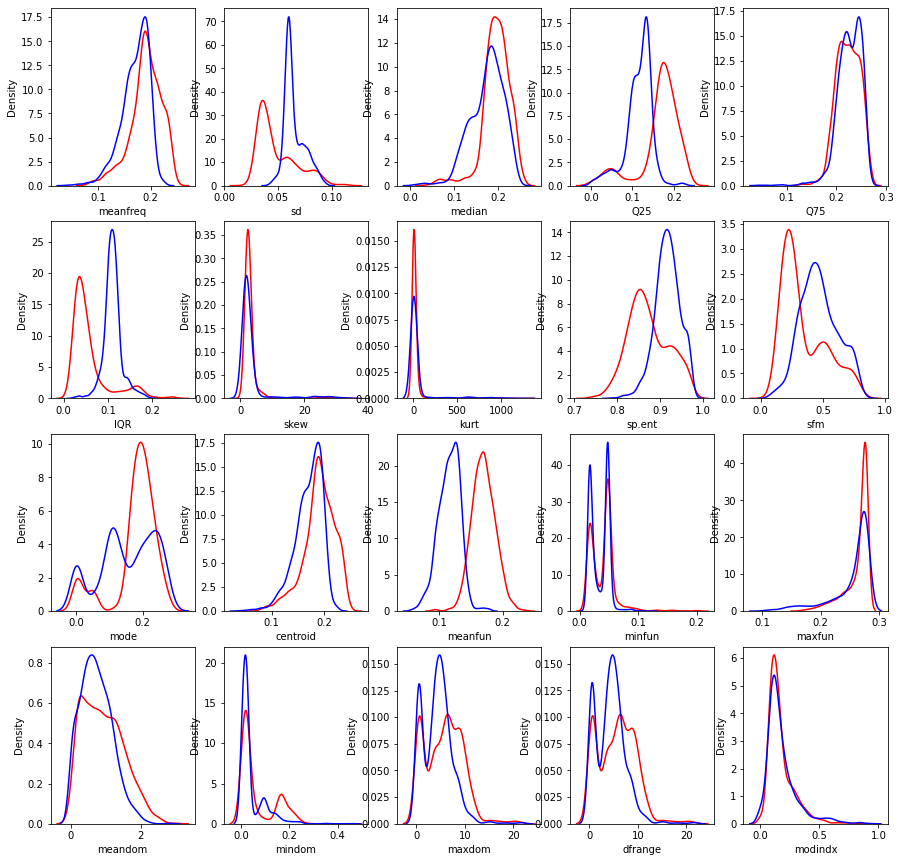

In [ ]:
plt.subplots(4,5,figsize=(15,15))
for i in range(1,21):
    plt.subplot(4,5,i)
    sns.kdeplot(data.loc[data['label'] == "female", data.columns[i-1]], color= 'red', label='Female')
    sns.kdeplot(data.loc[data['label'] == "male", data.columns[i-1]], color= 'blue', label='Male')

위의 그래프에서 보이는 것과 같이 Q25, IQR, meanfun 특성이 다른 특성들에 비해 성별에 따른 값의 차이가 큰 것을 확인할 수 있다. 

따라서 20개의 특성들 중 위의 세 가지 특성들만을 따로 뽑아내어 학습을 진행하였다. 

Q25(x), IQR(y), meanfun(z)에 따른 성별 분포는 다음 3차원 그래프와 같이 나타난다. 

In [ ]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

male = data[data.label == "male"]
female = data[data.label == "female"]

trace1 = go.Scatter3d(
    x=male.Q25,
    y=male.IQR,
    z=male.meanfun,
    mode='markers',
    name = "MALE",
    marker=dict(
        color='rgb(0, 51, 153)',
        size=3,
        line=dict(
            color='rgb(250, 250, 250)',
            width=0.1
        )
    )
)

trace2 = go.Scatter3d(
    x=female.Q25,
    y=female.IQR,
    z=female.meanfun,
    mode='markers',
    name = "FEMALE",
    marker=dict(
        color='rgb(255, 0, 0)',
        size=3,
        line=dict(
            color='rgb(250, 250, 250)',
            width=0.1
        )
    )
)

data1 = [trace1, trace2]
layout = go.Layout(
    title = ' 3D VOICE DATA ',
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data1, layout=layout)

iplot(fig)

**3) Data Preprocessing**

Min-Max Normalization을 통해 input 데이터를 정규화 한다. 이어서, output 데이터를 성별이 '남자'인 경우 1, '여자'인 경우 0의 값으로 만드는 전처리 과정을 진행하였다.

In [ ]:
data.label = [1 if each == "male" else 0 for each in data_voice.label]
y = data.label.values
x_data = data.drop(["label"],axis=1)
x_data = (x_data - np.min(x_data))/(np.max(x_data)-np.min(x_data)).values
x = x_data.iloc[:,[3,5,12]].values


이 중 80%(2534개)의 데이터를 학습데이터, 나머지 20%(634개)를 테스트데이터로 설정해준다.

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,random_state=0)

**4) Model Definition**

결과값을 남자 또는 여자로 분류하는 이진 분류 문제이기 때문에 활성함수로 'simoid'를 사용하여 모델을 정의하였다.  

In [ ]:
model = Sequential([Dense(1,input_shape=(3,), activation = 'sigmoid')])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 4         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


**5) Model Compile**

optimizer는 Stochastic Gradient Descent(SGD), loss는 Binary Cross entropy, 학습률은 0.2로 설정하여 모델을  컴파일하였다.

In [ ]:
sgd = keras.optimizers.SGD(0.2)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['binary_accuracy'])

**6) Model Learning**

epochs=300 으로 설정하고 학습을 진행하였다.

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = 300, verbose = 1)

Epoch 1/300
80/80 [==============================] - 14s 9ms/step - loss: 0.7128 - binary_accuracy: 0.6202 - val_loss: 0.5868 - val_binary_accuracy: 0.8249
Epoch 2/300
80/80 [==============================] - 0s 1ms/step - loss: 0.5667 - binary_accuracy: 0.8665 - val_loss: 0.5157 - val_binary_accuracy: 0.8486
Epoch 3/300
80/80 [==============================] - 0s 1ms/step - loss: 0.5071 - binary_accuracy: 0.8641 - val_loss: 0.4560 - val_binary_accuracy: 0.9148
Epoch 4/300
80/80 [==============================] - 0s 1ms/step - loss: 0.4481 - binary_accuracy: 0.9127 - val_loss: 0.4194 - val_binary_accuracy: 0.9164
Epoch 5/300
80/80 [==============================] - 0s 1ms/step - loss: 0.4227 - binary_accuracy: 0.9081 - val_loss: 0.3909 - val_binary_accuracy: 0.9211
Epoch 6/300
80/80 [==============================] - 0s 1ms/step - loss: 0.3916 - binary_accuracy: 0.9105 - val_loss: 0.3665 - val_binary_accuracy: 0.9274
Epoch 7/300
80/80 [==============================] - 0s 2ms/step - lo

Training loss와  Validation loss를 그래프로 비교해 보았다.

Training loss(0.1061)가 Validation loss(0.1184)보다 더 낮은 것을 확인 할 수 있다.

Text(0.5, 1.0, 'Traing and validation loss')

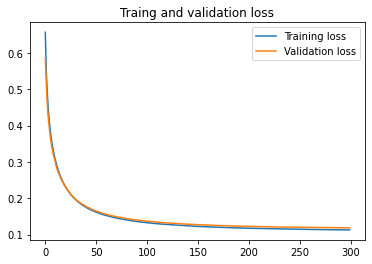

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss,label='Training loss')
plt.plot(val_loss,label='Validation loss')
plt.legend()
plt.title('Traing and validation loss' )

Training accuracy와  Validation accuracy 또한 그래프로 비교해 보았다.

Training accuracy(0.9691)가 Validation accuracy(0.9621)보다 더 높은 것을 확인 할 수 있다.

Text(0.5, 1.0, 'Traing and validation accuracy')

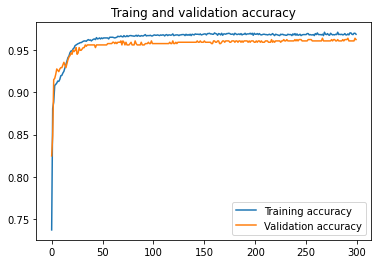

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
plt.plot(acc,label='Training accuracy')
plt.plot(val_acc,label='Validation accuracy')
plt.legend()
plt.title('Traing and validation accuracy' )


loss와 Accuracy 그래프를 통해 학습이 정상적으로 진행되었다는 사실을 확인 할 수 있다.

최종적으로 모델은 loss:0.1184, accuracy:0.9621 이라는 수치를 기록하였다.

In [ ]:
model.evaluate(x_test, y_test, verbose = 2 )

20/20 - 0s - loss: 0.1184 - binary_accuracy: 0.9621


[0.11841481924057007, 0.9621450901031494]

**7) Prediction**

마지막으로 테스트 세트에 있는 음성 샘플을 사용해 성별을 예측해 보았다. 

Text(0, 0.5, 'Predictions')

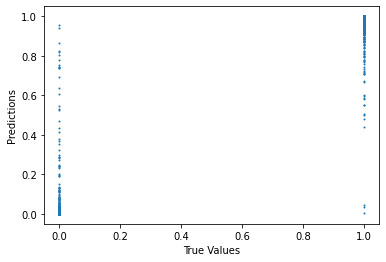

In [ ]:
test_predictions = model.predict(x_test).flatten()
plt.scatter(y_test,test_predictions,s=1)
plt.xlabel('True Values')
plt.ylabel('Predictions')

Text(0, 0.5, 'Count')

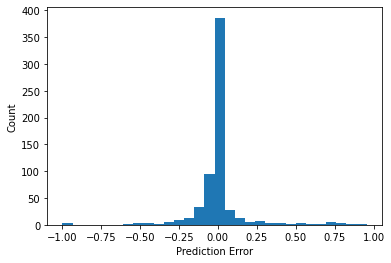

In [ ]:
error = test_predictions - y_test
plt.hist(error,bins = 30)
plt.xlabel('Prediction Error')
plt.ylabel('Count')

히스토그램을 통해 대부분의 데이터가 에러범위 
(-0.25, 0.25) 사이에 분포되어 있는 것을 확인 할 수 있었다.

**개선방안** : 이 학습과정에서는 20가지의 음성 특성 데이터 종류 중 3가지만 사용하여 학습을 진행하였다. 

따라서 input데이터의 개수를 더 늘려 학습을 진행한다면, Accuracy를 더 개선할 수 있을 것이다. 

epochs를 더 크게 설정 하는 방법 또한 Accuracy의 개선방안이 될 수 있다.

실제로 epochs를 300에서 1500으로 바꿔 학습을 진행했을 경우, 근소하지만 Accuracy향상이 이루어 진다는 사실을 확인할 수 있었다. 